In [1]:
# -*- coding: utf-8 -*-
from os import path, mkdir
import numpy as np
np.random.seed(1)
import random
random.seed(1)
import timeit
import cv2
from tqdm import tqdm
from skimage import measure
from multiprocessing import Pool
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.neighbors import KDTree
from skimage.morphology import watershed
from skimage.morphology import square, dilation
import pandas as pd
import math
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

In [2]:
oofs = []
for i in range(5):
    oof = pd.read_csv('../result/oof_fold{}.csv'.format(i))
    oofs.append(oof)
oof_all = pd.concat(oofs)
oof_all.to_csv('../result/oof_all.csv',index=False)

In [3]:
oof_detects = []
for i in range(5):
    oof = pd.read_csv('../result/oof_detection_fold{}.csv'.format(i))
    oof_detects.append(oof)
oof_det_all = pd.concat(oof_detects)
oof_det_all.to_csv('../result/oof_detect_all.csv',index=False)

In [4]:
ship_detection = None
for i in range(5):
    detect = pd.read_csv('../result/ship_detection_fold{}.csv'.format(i))
    if ship_detection is None:
        ship_detection = detect
    else:
        ship_detection.p_ship += detect.p_ship
ship_detection.p_ship /= 5
ship_detection.to_csv('../result/ship_detection_all.csv', index=False)

In [5]:
def get_mask(img_id, df):
    shape = (768,768)
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    masks = df.loc[img_id]['EncodedPixels']
    if(type(masks) == float): return img.reshape(shape)
    if(type(masks) == str): masks = [masks]
    for mask in masks:
        s = mask.split()
        for i in range(len(s)//2):
            start = int(s[2*i]) - 1
            length = int(s[2*i+1])
            img[start:start+length] = 1
    return img.reshape(shape).T

def extend_neighbor_features(inp, cur_prop, pred_props, neighbors, med_area, max_area):
    inp.append(neighbors.shape[0])
    median_area = med_area
    maximum_area = max_area
    if neighbors.shape[0] > 0:
        neighbors_areas = np.asarray([pred_props[j].area for j in neighbors])
        median_area = np.median(neighbors_areas)
        maximum_area = np.max(neighbors_areas)
    inp.append(median_area)
    inp.append(maximum_area)
    inp.append(cur_prop.area / median_area)
    inp.append(cur_prop.area / maximum_area)
    return inp

In [6]:
segment_df = pd.read_csv('../input/train_ship_segmentations_v2.csv.zip')
segment_df.set_index('ImageId', inplace=True)

In [7]:
oof = pd.read_csv('../result/oof_all.csv')
# oof = oof.drop('Unnamed: 0', axis=1)
oof.fillna('', inplace = True)
oof = oof.loc[oof.EncodedPixels.str.len() > 0]

In [8]:
oof_ship_detect = pd.read_csv('../result/oof_detect_all.csv')
oof_ship_detect.rename({'id':'ImageId'}, axis=1,inplace=True)
oof = pd.merge(oof, oof_ship_detect, on='ImageId')
oof.set_index('ImageId', inplace=True)

In [9]:
oof.shape

(126187, 2)

In [10]:
img_ids = oof.index.unique()

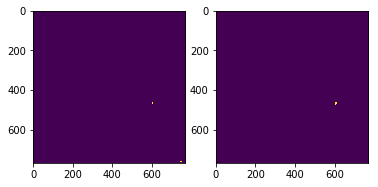

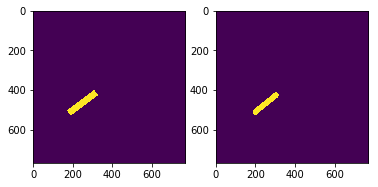

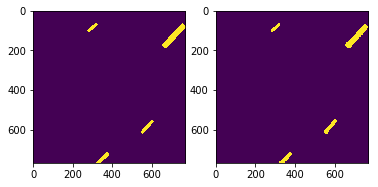

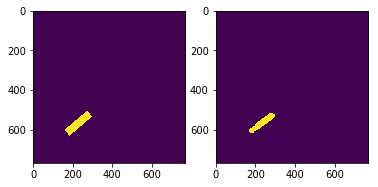

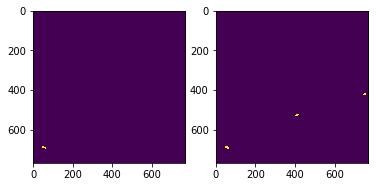

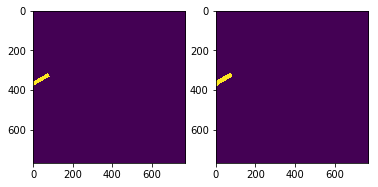

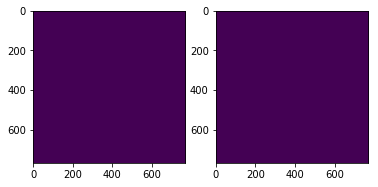

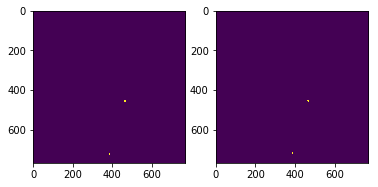

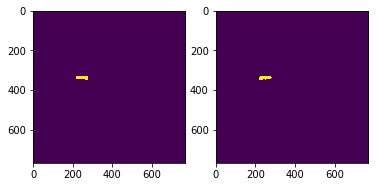

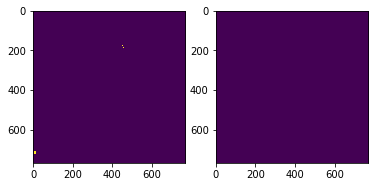

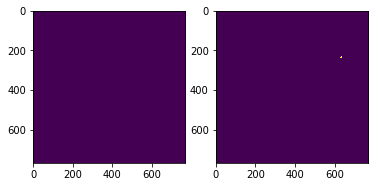

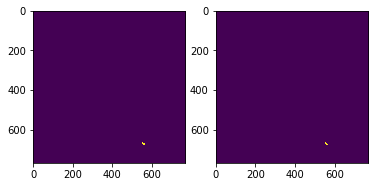

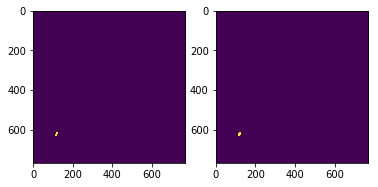

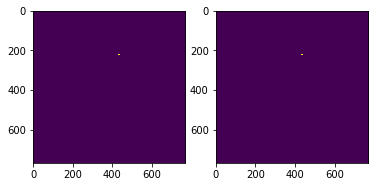

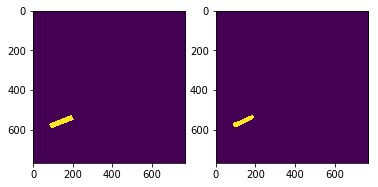

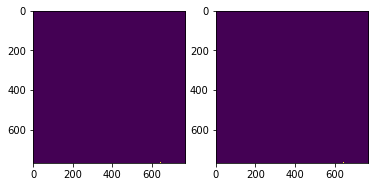

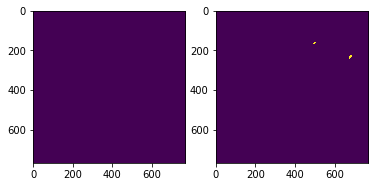

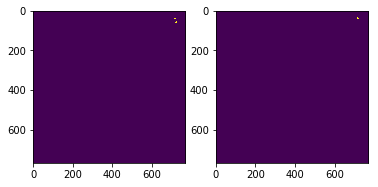

In [11]:
for i in range(18):
    testid = img_ids[i]
    premask = get_mask(testid, oof)
    truemask = get_mask(testid, segment_df)

    fig, axis = plt.subplots(1,2)
    axis[0].imshow(truemask)
    axis[1].imshow(premask)

In [12]:
def get_inputs(imageid, pre_df, seg_df = None):
    inputs = []    
    
    pred_msk = get_mask(imageid, pre_df)
    y_pred = measure.label(pred_msk, neighbors=8, background=0)
    ship_pro = pre_df.loc[imageid, 'p_ship'].mean()
    
    props = measure.regionprops(y_pred)
    for i in range(len(props)):
        if props[i].area < 10:
            y_pred[y_pred == i+1] = 0
    pred_labels = measure.label(y_pred, neighbors=8, background=0)
    pred_props = measure.regionprops(y_pred)
    init_count = len(pred_props)

    coords = [pr.centroid for pr in pred_props]
#     print('len(coords)', len(coords))
    if len(coords) > 0:
#         print('make neighbors')
        t = KDTree(coords)
        neighbors100 = t.query_radius(coords, r=50)
        neighbors200 = t.query_radius(coords, r=100)
        neighbors300 = t.query_radius(coords, r=150)
        neighbors400 = t.query_radius(coords, r=200)
        areas = np.asarray([pr.area for pr in props])
        med_area = np.median(areas)
        max_area = np.max(areas)
    
    for i in range(len(pred_props)):
        cur_prop = pred_props[i]
        is_on_border = 1 * ((cur_prop.bbox[0] <= 1) | (cur_prop.bbox[1] <= 1) | (cur_prop.bbox[2] >= y_pred.shape[0] - 1) | (cur_prop.bbox[3] >= y_pred.shape[1] - 1))
  
        msk_reg = pred_labels[cur_prop.bbox[0]:cur_prop.bbox[2], cur_prop.bbox[1]:cur_prop.bbox[3]] == i+1
        pred_reg = y_pred[cur_prop.bbox[0]:cur_prop.bbox[2], cur_prop.bbox[1]:cur_prop.bbox[3]]
        
        contours = cv2.findContours((msk_reg * 255).astype(dtype=np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours[1]) > 0:
            cnt = contours[1][0]
            min_area_rect = cv2.minAreaRect(cnt)
        
        inp = []
        inp.append(ship_pro)
        inp.append(cur_prop.area)
        inp.append(cur_prop.area / med_area)
        inp.append(cur_prop.area / max_area)
        if len(contours[1]) > 0:
            inp.append(cv2.isContourConvex(cnt) * 1.0)
            inp.append(min(min_area_rect[1]))
            inp.append(max(min_area_rect[1]))
            if max(min_area_rect[1]) > 0:
                inp.append(min(min_area_rect[1]) / max(min_area_rect[1]))
            else:
                inp.append(0)
            inp.append(min_area_rect[2])
        else:
            inp.append(0)
            inp.append(0)
            inp.append(0)
            inp.append(0)
            inp.append(0)
        inp.append(cur_prop.convex_area)
        inp.append(cur_prop.solidity)
        inp.append(cur_prop.eccentricity)
        inp.append(cur_prop.extent)
        inp.append(cur_prop.perimeter)
        inp.append(cur_prop.major_axis_length)
        inp.append(cur_prop.minor_axis_length)
        if(cur_prop.minor_axis_length > 0):
            inp.append(cur_prop.minor_axis_length / cur_prop.major_axis_length)
        else:
            inp.append(0)
            
        inp.append(cur_prop.euler_number)
        inp.append(cur_prop.equivalent_diameter)
        inp.append(cur_prop.perimeter ** 2 / (4 * cur_prop.area * math.pi))
        
        inp.append(is_on_border)        
        inp.append(init_count)
        inp.append(med_area)
        inp.append(cur_prop.area / med_area)

        inp = extend_neighbor_features(inp, cur_prop, pred_props, neighbors100[i], med_area, max_area)
        inp = extend_neighbor_features(inp, cur_prop, pred_props, neighbors200[i], med_area, max_area)
        inp = extend_neighbor_features(inp, cur_prop, pred_props, neighbors300[i], med_area, max_area)
        inp = extend_neighbor_features(inp, cur_prop, pred_props, neighbors400[i], med_area, max_area)
        
        
        inputs.append(np.asarray(inp))
        
    inputs = np.asarray(inputs)
    if seg_df is None:
        return inputs, pred_labels
    else:
        outputs = []
        truth_labels = get_mask(imageid, seg_df)
        truth_labels = measure.label(truth_labels, neighbors=8, background=0)
        truth_props = measure.regionprops(truth_labels)
        
        m = np.zeros((len(pred_props), len(truth_props)))
        
        for x in range(pred_labels.shape[1]):
            for y in range(pred_labels.shape[0]):
                if pred_labels[y, x] > 0 and truth_labels[y, x] > 0:
                    m[pred_labels[y, x]-1, truth_labels[y, x]-1] += 1
                    
        truth_used = set([])
        for i in range(len(pred_props)): 
            max_iou = 0
            for j in range(len(truth_props)):
                if m[i, j] > 0:
                    iou = m[i, j] / (pred_props[i].area + truth_props[j].area - m[i, j])
                    if iou > max_iou:
                        max_iou = iou
                    if iou > 0.5:
                        truth_used.add(j)
            if max_iou <= 0.5:
                max_iou = 0
            outputs.append(max_iou)
            
        outputs = np.asarray(outputs)
        fn = len(truth_props) - len(truth_used)
        
        return inputs, pred_labels, outputs, fn

In [15]:
inputs = []
outputs = []
for testid in tqdm_notebook(img_ids):
    inps, pred_labels, outs, fn = get_inputs(testid, oof, segment_df)
    inputs.append(inps)
    outputs.append(outs)

In [17]:
num_split_iters = 2
for it in range(num_split_iters):
    kf = KFold(n_splits=5, random_state=it + 1, shuffle=True)
    it2 = -1
    for train_idxs, test_idxs in kf.split(inputs):
        print(len(train_idxs), len(test_idxs))
        it2 += 1

        cur_seed = it*1000+it2
        random.seed(cur_seed)
        np.random.seed(cur_seed)

        lr = random.random()*0.1 + 0.02
        ff = random.random()*0.5 + 0.5
        nl = random.randint(6, 50)
        print('training lgb', it, it2, 'lr:', lr, 'ff:', ff, 'nl:', nl)

        train_inp = None
        train_otp = None
        for i in train_idxs:
            if train_inp is None:
                if inputs[i].shape[0]>0:
                    train_inp = inputs[i].copy()
                    train_otp = outputs[i].copy()
            else:
                if inputs[i].shape[0]>0:
                    train_inp = np.concatenate((train_inp, inputs[i]), axis=0)
                    train_otp = np.concatenate((train_otp, outputs[i]), axis=0)

        test_inp = None 
        test_otp = None
        for i in test_idxs:
            if test_inp is None:
                if inputs[i].shape[0]>0:
                    test_inp = inputs[i].copy()
                    test_otp = outputs[i].copy()
            else:
                if inputs[i].shape[0]>0:
                    test_inp = np.concatenate((test_inp, inputs[i]), axis=0)
                    test_otp = np.concatenate((test_otp, outputs[i]), axis=0)

        lgb_train = lgb.Dataset(train_inp, train_otp)
        lgb_eval = lgb.Dataset(test_inp, test_otp, reference=lgb_train)

        params = {
            'task': 'train',
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'l2'},
            'num_leaves': nl,
            'learning_rate': lr,
            'feature_fraction': ff,
            'bagging_fraction': 0.95,
            'bagging_freq': 1,
            'verbosity': 0,
            'seed': cur_seed,
            'num_threads': 6,
            "verbose_eval ": -1,
        }

        gbm = lgb.train(params,
                        lgb_train,
                        num_boost_round=30000,
                        valid_sets=lgb_eval,
                        early_stopping_rounds=100,
                        verbose_eval = 200)

        gbm.save_model(path.join('lgb_models', 'gbm_{0}_{1}.txt'.format(it, it2)))

#         break
#     break

41999 10500
training lgb 0 0 lr: 0.10444218515250482 ff: 0.8789772014701512 nl: 32
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's l2: 0.0369949
[400]	valid_0's l2: 0.0349092
[600]	valid_0's l2: 0.0336296
[800]	valid_0's l2: 0.0326852
[1000]	valid_0's l2: 0.0320332
[1200]	valid_0's l2: 0.0314338
[1400]	valid_0's l2: 0.0309303
[1600]	valid_0's l2: 0.0305503
[1800]	valid_0's l2: 0.0302095
[2000]	valid_0's l2: 0.0298739
[2200]	valid_0's l2: 0.0296129
[2400]	valid_0's l2: 0.0293838
[2600]	valid_0's l2: 0.0292048
[2800]	valid_0's l2: 0.0290455
[3000]	valid_0's l2: 0.0289165
[3200]	valid_0's l2: 0.0287901
[3400]	valid_0's l2: 0.0286359
[3600]	valid_0's l2: 0.0285147
[3800]	valid_0's l2: 0.0283933
[4000]	valid_0's l2: 0.028297
[4200]	valid_0's l2: 0.0282284
[4400]	valid_0's l2: 0.028176
[4600]	valid_0's l2: 0.0281188
[4800]	valid_0's l2: 0.0280605
[5000]	valid_0's l2: 0.0280277
[5200]	valid_0's l2: 0.0279851
[5400]	valid_0's l2: 0.0279488
[5600]	valid_0's l2: 0.

Early stopping, best iteration is:
[10293]	valid_0's l2: 0.0306587
41999 10500
training lgb 0 3 lr: 0.04379646270918914 ff: 0.7721146126479759 nl: 29
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's l2: 0.0380938
[400]	valid_0's l2: 0.0365066
[600]	valid_0's l2: 0.0353543
[800]	valid_0's l2: 0.0344858
[1000]	valid_0's l2: 0.0337102
[1200]	valid_0's l2: 0.0330743
[1400]	valid_0's l2: 0.0325169
[1600]	valid_0's l2: 0.0320579
[1800]	valid_0's l2: 0.0316494
[2000]	valid_0's l2: 0.0313277
[2200]	valid_0's l2: 0.0310054
[2400]	valid_0's l2: 0.0306897
[2600]	valid_0's l2: 0.0304041
[2800]	valid_0's l2: 0.0301427
[3000]	valid_0's l2: 0.0298961
[3200]	valid_0's l2: 0.0296696
[3400]	valid_0's l2: 0.0294711
[3600]	valid_0's l2: 0.0292875
[3800]	valid_0's l2: 0.029116
[4000]	valid_0's l2: 0.0289526
[4200]	valid_0's l2: 0.028817
[4400]	valid_0's l2: 0.0286698
[4600]	valid_0's l2: 0.0285328
[4800]	valid_0's l2: 0.0283914
[5000]	valid_0's l2: 0.0282731
[5200]	valid_0's l

[20400]	valid_0's l2: 0.0261889
[20600]	valid_0's l2: 0.0261783
[20800]	valid_0's l2: 0.0261706
[21000]	valid_0's l2: 0.0261642
[21200]	valid_0's l2: 0.0261547
[21400]	valid_0's l2: 0.026147
[21600]	valid_0's l2: 0.0261429
[21800]	valid_0's l2: 0.0261335
[22000]	valid_0's l2: 0.0261305
[22200]	valid_0's l2: 0.0261218
[22400]	valid_0's l2: 0.026118
[22600]	valid_0's l2: 0.0261124
[22800]	valid_0's l2: 0.0261093
[23000]	valid_0's l2: 0.026103
[23200]	valid_0's l2: 0.0260994
[23400]	valid_0's l2: 0.026096
[23600]	valid_0's l2: 0.0260914
[23800]	valid_0's l2: 0.0260879
[24000]	valid_0's l2: 0.0260846
[24200]	valid_0's l2: 0.0260817
Early stopping, best iteration is:
[24105]	valid_0's l2: 0.0260815
41999 10500
training lgb 1 0 lr: 0.09773566427005641 ff: 0.8349127797796249 nl: 12
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's l2: 0.0385145
[400]	valid_0's l2: 0.0370051
[600]	valid_0's l2: 0.0362267
[800]	valid_0's l2: 0.0354775
[1000]	valid_0's l2: 0.034908
[

[400]	valid_0's l2: 0.0354388
[600]	valid_0's l2: 0.0341485
[800]	valid_0's l2: 0.033171
[1000]	valid_0's l2: 0.032358
[1200]	valid_0's l2: 0.0317871
[1400]	valid_0's l2: 0.0313008
[1600]	valid_0's l2: 0.0308335
[1800]	valid_0's l2: 0.0304814
[2000]	valid_0's l2: 0.0301351
[2200]	valid_0's l2: 0.0298279
[2400]	valid_0's l2: 0.0295717
[2600]	valid_0's l2: 0.0293234
[2800]	valid_0's l2: 0.029129
[3000]	valid_0's l2: 0.0289438
[3200]	valid_0's l2: 0.0287511
[3400]	valid_0's l2: 0.0285949
[3600]	valid_0's l2: 0.0284402
[3800]	valid_0's l2: 0.0282729
[4000]	valid_0's l2: 0.0281541
[4200]	valid_0's l2: 0.0280633
[4400]	valid_0's l2: 0.0279463
[4600]	valid_0's l2: 0.0278582
[4800]	valid_0's l2: 0.0277553
[5000]	valid_0's l2: 0.0276763
[5200]	valid_0's l2: 0.0275957
[5400]	valid_0's l2: 0.027529
[5600]	valid_0's l2: 0.0274559
[5800]	valid_0's l2: 0.027391
[6000]	valid_0's l2: 0.0273354
[6200]	valid_0's l2: 0.027274
[6400]	valid_0's l2: 0.0272247
[6600]	valid_0's l2: 0.0271875
[6800]	valid_0's 